# Telugu2Vec Language Modeling

The goal of this notebook is to train Telugu word embeddings using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182)--basically LSTM with dropouts--with data from [Wikipedia](https://archive.org/download/tewiki-20170301/tewiki-20170301-pages-articles.xml.bz2).

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import dill as pickle
import json
from IPython.display import Image
from IPython.core.display import HTML

from spacy.lang.hi import *

import re
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

In [2]:
from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

In [3]:
PATH='/home/gokul/fastai/tutorials/'
# path to the xml wikipedia dump

EXT_PATH = 'textract/'
TRN_PATH = 'ttrain/'
VAL_PATH = 'tvalid/'
SAMPLE_PATH = 'tsample/'

EXT = f'{PATH}{EXT_PATH}'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
SAMPLE = f'{PATH}{SAMPLE_PATH}'

ext1 = !ls {EXT}
temp = f'{PATH}{EXT_PATH}{ext1[0]}/'
ext_files = !ls {temp} 
sample_files = !ls {VAL}

In [4]:
sample_files

['wiki_01.txt', 'wiki_03.txt', 'wiki_05.txt', 'wiki_07.txt', 'wiki_22.txt']

## Text Cleaning

In [97]:
# !python wikiextractor/WikiExtractor.pytewiki-20170301-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude

### Save as Plain Text

In [5]:
%%time
%%prun


def clean_files(extracted_filelist, TRN):    
    cleaned_all = []
    for ext_file in extracted_filelist:
        input_file = f'{temp}{ext_file}'
        with open(input_file,'r', encoding='utf-8') as f:
            raw_txt = f.readlines()
            cleaned_doc = []
            for line in raw_txt:
                new_line = re.sub('<[^<]+?>', '', line)
                new_line = re.sub('__[^<]+?__', '', new_line) 
                new_line = new_line.strip()
                if new_line != '':
                    cleaned_doc.append(new_line)

            new_doc = "\n".join(cleaned_doc)
            cleaned_all.append(new_doc)
            with open(f"{TRN}{ext_file}.txt", "w", encoding='utf-8') as text_file:
                text_file.write(new_doc)
    return cleaned_all

cleaned_all = clean_files(ext_files, TRN)

 CPU times: user 5.1 s, sys: 503 ms, total: 5.6 s
Wall time: 5.62 s


In [6]:
print(f'Preview:\n{cleaned_all[0][:500]}\n\nLength of list (should be equal to number of documents): {len(cleaned_all)}')

Preview:
మొదటి పేజీ
గుంటూరు జిల్లా
గుంటూరు జిల్లా గుంటూరు జిల్లా వివరము సేకరించిన తేది 2012-01-01 11,391 చ.కి.మీ. ల విస్తీర్ణములో వ్యాపించి, 48,89,230 (2011 గణన) జనాభా కలిగిఉన్నది. ఆగ్నేయాన బంగాళాఖాతము, దక్షిణాన ప్రకాశం జిల్లా, పశ్చిమాన మహబూబ్ నగర్ జిల్లా, మరియు వాయువ్యాన నల్గొండ జిల్లా సరిహద్దులుగా ఉన్నాయి. దీని ముఖ్యపట్టణం గుంటూరు
ఈ జిల్లాకు అతి పురాతన చరిత్ర వుంది. మౌర్యులు, శాతవాహనులు, పల్లవులు, చాళుక్యులు, కాకతీయులు, విజయనగర రాజులు పరిపాలించారు. పల్నాటి యుద్ధం ఇక్కడే జరిగింది. మొగలు సామ్రాజ్యం, నిజా

Length of list (should be equal to number of documents): 28


### Create Validation Set

In [98]:
import random

random.shuffle(trn_files)
len_valid = int(0.2 * len(trn_files)) 
val_files = trn_files[:len_valid]
trn_files = trn_files[len_valid:]

In [12]:
val_files,trn_files

(['wiki_05.txt', 'wiki_22.txt', 'wiki_01.txt', 'wiki_07.txt', 'wiki_03.txt'],
 ['wiki_23.txt',
  'wiki_00.txt',
  'wiki_06.txt',
  'wiki_10.txt',
  'wiki_16.txt',
  'wiki_15.txt',
  'wiki_25.txt',
  'wiki_13.txt',
  'wiki_14.txt',
  'wiki_04.txt',
  'wiki_18.txt',
  'wiki_26.txt',
  'wiki_27.txt',
  'wiki_21.txt',
  'wiki_02.txt',
  'wiki_24.txt',
  'wiki_09.txt',
  'wiki_20.txt',
  'wiki_08.txt',
  'wiki_11.txt',
  'wiki_19.txt',
  'wiki_12.txt',
  'wiki_17.txt'])

In [13]:
# import shutil, os
# for root, dirs, files in os.walk(TRN):
#     for file in files:
#         if file.endswith(".txt") & (file in val_files):
#             shutil.move(os.path.join(root, file),VAL)

In [8]:
trn_files = !ls {TRN}
val_files = !ls {VAL}
print(trn_files), print(val_files), print(len(trn_files)), print(len(val_files))

['wiki_00.txt', 'wiki_01.txt', 'wiki_02.txt', 'wiki_03.txt', 'wiki_04.txt', 'wiki_05.txt', 'wiki_06.txt', 'wiki_07.txt', 'wiki_08.txt', 'wiki_09.txt', 'wiki_10.txt', 'wiki_11.txt', 'wiki_12.txt', 'wiki_13.txt', 'wiki_14.txt', 'wiki_15.txt', 'wiki_16.txt', 'wiki_17.txt', 'wiki_18.txt', 'wiki_19.txt', 'wiki_20.txt', 'wiki_21.txt', 'wiki_22.txt', 'wiki_23.txt', 'wiki_24.txt', 'wiki_25.txt', 'wiki_26.txt', 'wiki_27.txt']
['wiki_01.txt', 'wiki_03.txt', 'wiki_05.txt', 'wiki_07.txt', 'wiki_22.txt']
28
5


(None, None, None, None)

## Text Processing

### Tokenizer

In [9]:
def word_tokenize(document):
    nlp = Hindi()
    return [token.text for token in nlp(document)]
    
def docs_tokenize(documents_as_lists):   
    for document in documents_as_lists:
        tokens = word_tokenize(document)
        tokens_list.extend(tokens)
    
    return tokens_list

In [10]:
%%time
tokens_filename = "tokens_list_telugu.txt"
tokens_list = []

try:
    print(f'Reading from {tokens_filename}')
    with open(tokens_filename, "r") as f:
         tokens_list = json.load(f)
    
except FileNotFoundError:
    print(f'FileNotFound. Trying to tokenize from cleaned_all')
    tokens_list = docs_tokenize(cleaned_all)
    
    with open('tokens_list_telugu.txt', 'w') as outfile:
        json.dump(tokens_list, outfile)

print(f'Found {len(tokens_list)} tokens')

Reading from tokens_list_telugu.txt
Found 15837730 tokens
CPU times: user 7.59 s, sys: 1.07 s, total: 8.66 s
Wall time: 8.66 s


### Min Count

In [38]:
# TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
# freqs = pd.DataFrame.from_dict(TEXT.vocab.freqs,orient='index')
# freqs.sort_values(0,ascending=False).head(10)

In [ ]:
# cnt = []
# for i in range(49):
#     row_cnt = freqs[freqs[0]>=i+1].shape[0]
#     cnt.append(row_cnt)

In [ ]:
# plt.plot(cnt)
# plt.axvline(x=10,color='red', linestyle='--')

In [ ]:
# #number of legitimate thai words at freqs
# freqs[freqs[0]<=10].sort_values(ascending=False,by=0).head(10)

### Data Loader

In [11]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled

In [12]:
TEXT = data.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=32
#backprop through time
bptt=70

In [13]:
#FILES = dict(train=f'{SAMPLE_PATH}', validation=f'{SAMPLE_PATH}', test=f'{SAMPLE_PATH}')
FILES = dict(train=f'{TRN_PATH}', validation=f'{VAL_PATH}', test=f'{VAL_PATH}')

In [14]:
FILES,PATH

({'test': 'tvalid/', 'train': 'ttrain/', 'validation': 'tvalid/'},
 '/home/gokul/fastai/tutorials/')

In [15]:
%%time
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=50)

CPU times: user 24min 17s, sys: 4.62 s, total: 24min 21s
Wall time: 24min 22s


In [16]:
%%time
pickle.dump(TEXT, open(f'{PATH}/tmodels/TEXT_min_freq50.pkl','wb'))

CPU times: user 1.04 s, sys: 132 ms, total: 1.18 s
Wall time: 1.2 s


In [17]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(6847, 27174, 1, 15339535)

In [18]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ',', '"', 'మరియు', '(', ')', 'ఈ', '.', 'ఒక', '-', 'యొక్క']

In [19]:
TEXT.vocab.stoi['మరియు']

4

In [20]:
md.trn_ds[0].text[:12]

['మల్లి',
 'మస్తాన్\u200c',
 'బాబు',
 'మల్లి',
 'మస్తాన్\u200cబాబు',
 'ఆంధ్ర',
 'ప్రదేశ్',
 'కు',
 'చెందిన',
 'పర్వతారోహకుడు.',
 'పర్వతారోహణలో',
 'గిన్నిస్\u200c']

In [21]:
next(iter(md.trn_dl))

(Variable containing:
  15589      0    286  ...    8262      4      0
      0      7   3140  ...       0    272  22025
   1951      0    154  ...       0    831      9
         ...            ⋱           ...         
    742    429      0  ...      15      0      0
      2      2      0  ...       9   1223      3
      0   2207    108  ...       0   3961    954
 [torch.cuda.LongTensor of size 68x32 (GPU 0)], Variable containing:
      0
      7
   3140
   ⋮   
    158
   7224
   2450
 [torch.cuda.LongTensor of size 2176 (GPU 0)])

In [22]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

Variable containing:
 15589
     0
  1951
 15589
     0
   180
   288
   119
    15
     0
[torch.cuda.LongTensor of size 10x1 (GPU 0)]

## Language Model

### Training

In [23]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [24]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [25]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|███████▉  | 5470/6847 [19:12<04:50,  4.75it/s, loss=23.3]

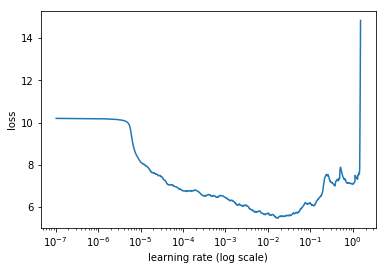

In [26]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)
learner.sched.plot()

In [27]:
learner.fit(1e-3, 1, wds=1e-6, cycle_len=1, cycle_save_name='telugu_adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 46/6847 [00:09<24:03,  4.71it/s, loss=10.2]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/gokul/anaconda2/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gokul/anaconda2/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gokul/anaconda2/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      5.294103   4.540195  



[4.540195]

In [28]:
learner.save_encoder('telugu_adam3_20')

# Testing Results

In [41]:
!pip install git+git://github.com/irshadbhat/indic-tokenizer.git

  Cloning git://github.com/irshadbhat/indic-tokenizer.git to /tmp/pip-YhcwTq-build
  Running setup.py install for indic-tokenizer ... done
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [49]:
from irtokz import IndicTokenizer

In [50]:
tok = IndicTokenizer(lang='tel', split_sen=True)

In [69]:
m=learner.model
ss="మొదటి పేజీ గుంటూరు జిల్లా గుంటూరు జిల్లా గుంటూరు జిల్లా వివరము సేకరించిన తేది 2012-01-01 11,391 చ.కి.మీ. ల విస్తీర్ణములో వ్యాపించి, 48,89,230 (2011 గణన) జనాభా కలిగిఉన్నది. ఆగ్నేయాన బంగాళాఖాతము, దక్షిణాన ప్రకాశం జిల్లా, పశ్చిమాన మహబూబ్ నగర్ జిల్లా, మరియు వాయువ్యాన నల్గొండ జిల్లా సరిహద్దులుగా ఉన్నాయి. దీని ముఖ్యపట్టణం గుంటూరుఈ జిల్లాకు అతి పురాతన చరిత్ర వుంది. మౌర్యులు, శాతవాహనులు, పల్లవులు, చాళుక్యులు, కాకతీయులు, విజయనగర రాజులు పరిపాలించారు. పల్నాటి యుద్ధం ఇక్కడే జరిగింది. మొగలు సామ్రాజ్యం, నిజా"
s = [tok.tokenize(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'మ ొ ద ట ి   ప ే జ ీ   గ ు ం ట ూ ర ు   జ ి ల ్ ల ా   గ ు ం ట ూ ర ు   జ ి ల ్ ల ా   గ ు ం ట ూ ర ు   జ ి ల ్ ల ా   వ ి వ ర మ ు   స ే క ర ి ం చ ి న   త ే ద ి   2 0 1 2   -   0 1   -   0 1   1 1 , 3 9 1   చ   . \n క ి   . \n మ ీ   . \n ల   వ ి స ్ త ీ ర ్ ణ మ ు ల ో   వ ్ య ా ప ి ం చ ి   ,   4 8 , 8 9 , 2 3 0   (   2 0 1 1   గ ణ న   )   జ న ా భ ా   క ల ి గ ి ఉ న ్ న ద ి   . \n ఆ గ ్ న ే య ా న   బ ం గ ా ళ ా ఖ ా త మ ు   ,   ద క ్ ష ి ణ ా న   ప ్ ర క ా శ ం   జ ి ల ్ ల ా   ,   ప శ ్ చ ి మ ా న   మ హ బ ూ బ ్   న గ ర ్   జ ి ల ్ ల ా   ,   మ ర ి య ు   వ ా య ు వ ్ య ా న   న ల ్ గ ొ ం డ   జ ి ల ్ ల ా   స ర ి హ ద ్ ద ు ల ు గ ా   ఉ న ్ న ా య ి   . \n ద ీ న ి   మ ు ఖ ్ య ప ట ్ ట ణ ం   గ ు ం ట ూ ర ు ఈ   జ ి ల ్ ల ా క ు   అ త ి   ప ు ర ా త న   చ ర ి త ్ ర   వ ు ం ద ి   . \n మ ౌ ర ్ య ు ల ు   ,   శ ా త వ ా హ న ు ల ు   ,   ప ల ్ ల వ ు ల ు   ,   చ ా ళ ు క ్ య ు ల ు   ,   క ా క త ీ య ు ల ు   ,   వ ి జ య న గ ర   ర ా జ ు ల ు   ప ర ి ప ా ల ి ం చ ా ర ు   . \n ప ల ్ న ా ట ి   య ు ద ్ ధ ం   ఇ క ్ క డ ే   జ ర ి గ ి 

In [71]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res, *other_things = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [72]:
other_things

[[Variable containing:
  ( 0 ,.,.) = 
    2.1634e-02 -3.5111e-02  1.0812e-01  ...   5.5863e-04  1.6148e-02 -2.3574e-01
  
  ( 1 ,.,.) = 
   -4.6288e-01  4.3394e-02 -2.3430e-02  ...   2.6253e-02  8.6652e-02 -2.8255e-03
  
  ( 2 ,.,.) = 
    1.4215e-02  9.4392e-02 -8.2410e-03  ...   5.3444e-03  2.3075e-02  1.0896e-01
  ... 
  
  (522,.,.) = 
   -8.2637e-02 -5.6687e-01  1.1741e-02  ...   1.0140e-02 -6.9116e-02 -3.3787e-04
  
  (523,.,.) = 
    4.8953e-03 -4.5771e-01  1.5075e-02  ...   2.5215e-02  9.5703e-03 -7.8923e-02
  
  (524,.,.) = 
   -6.9392e-01 -1.9462e-02 -6.0734e-02  ...   1.2012e-01  5.2835e-02 -1.3855e-04
  [torch.cuda.FloatTensor of size 525x1x500 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
   -6.9698e-03 -4.3704e-02 -3.4458e-01  ...  -9.7302e-02  6.7560e-03 -9.4302e-03
  
  ( 1 ,.,.) = 
   -2.8246e-02  6.6851e-03  2.7688e-02  ...  -2.5097e-02  4.4395e-02  2.9510e-02
  
  ( 2 ,.,.) = 
   -2.0216e-02  3.5162e-07  6.9255e-01  ...  -2.3232e-01  9.8550e-02  2.3627e-01
  ... 
  


In [73]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', '.', ',', 'లో', '-', '(', ':', ')', '\xa0', "'"]

In [74]:
print(ss,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

మొదటి పేజీ గుంటూరు జిల్లా గుంటూరు జిల్లా గుంటూరు జిల్లా వివరము సేకరించిన తేది 2012-01-01 11,391 చ.కి.మీ. ల విస్తీర్ణములో వ్యాపించి, 48,89,230 (2011 గణన) జనాభా కలిగిఉన్నది. ఆగ్నేయాన బంగాళాఖాతము, దక్షిణాన ప్రకాశం జిల్లా, పశ్చిమాన మహబూబ్ నగర్ జిల్లా, మరియు వాయువ్యాన నల్గొండ జిల్లా సరిహద్దులుగా ఉన్నాయి. దీని ముఖ్యపట్టణం గుంటూరుఈ జిల్లాకు అతి పురాతన చరిత్ర వుంది. మౌర్యులు, శాతవాహనులు, పల్లవులు, చాళుక్యులు, కాకతీయులు, విజయనగర రాజులు పరిపాలించారు. పల్నాటి యుద్ధం ఇక్కడే జరిగింది. మొగలు సామ్రాజ్యం, నిజా 

. the the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first ...


In [78]:
m = learner.model
#pickle.dump(m,open(f'{PATH}models/wiki_lang.pkl','wb'))
TEXT = pickle.load(open(f'{PATH}tmodels/TEXT_min_freq50.pkl','rb'))
#m = pickle.load(open(f'{PATH}tmodels/wiki_lang.pkl','rb'))
m[0].bs=1
m.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(27174, 300, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(27174, 300, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500, dropout=0.05)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500, dropout=0.05)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300, dropout=0.05)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=27174, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [79]:
def gen_text(ss,topk):
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [TEXT.vocab.itos[o] for o in to_np(pred_i)]

def gen_sentences(ss,nb_words):
    result = []
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        result.append(TEXT.vocab.itos[pred_i.data[0]])
        pred,*_ = m(pred_i[0].unsqueeze(0))
    return(result)

In [80]:
ss="""మొదటి"""
gen_text(ss,10)

['<unk>',
 'సంవత్సరం',
 'రోజు',
 'సారి',
 'ప్రపంచ',
 'ఏడాది',
 'స్థానంలో',
 'విధంగా',
 'సమయంలో',
 'సారిగా']

In [81]:
''.join(gen_sentences(ss,50))

'సంవత్సరంతరువాత,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం,ఈసంవత్సరం'

## Embeddings

### Extract

In [82]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

In [83]:
emb_np.shape

(27174, 300)

In [84]:
TEXT = pickle.load(open(f'{PATH}/tmodels/TEXT_min_freq50.pkl','rb'))

In [89]:
TEXT.vocab.set_vectors(vectors=emb_weights.data,dim=300,stoi=TEXT.vocab.stoi)
pickle.dump(TEXT, open(f'{PATH}tmodels/TEXT_vec.pkl','wb'))

In [90]:
TEXT_vec = pickle.load(open(f'{PATH}tmodels/TEXT_vec.pkl','rb'))

In [93]:
telugu2vec = pd.DataFrame(to_np(TEXT_vec.vocab.vectors))
telugu2vec.index = TEXT_vec.vocab.itos
telugu2vec.head(10)

0         1         2         3         4         5         6    \
<unk> -0.161400 -0.132135  0.124876 -0.438368  0.175198 -0.379056 -0.499405   
<pad>  0.111256  0.118246 -0.096444  0.218259 -0.075446  0.185479  0.214657   
,     -0.344179 -0.479996  0.282458 -0.382394  0.208109 -0.421042 -0.316147   
"     -0.408896 -0.103209 -0.037660 -0.385375 -0.103947 -0.354062 -0.063167   
మరియు -0.039602 -0.101947 -0.023978 -0.268156 -0.020079 -0.283751 -0.275455   
(     -0.395420 -0.026604 -0.081027 -0.379568 -0.030601 -0.317772 -0.259387   
)     -0.251607  0.179833 -0.111103 -0.345995  0.479954 -0.385617  0.368566   
ఈ      0.227717 -0.386897  0.290830 -0.120764  0.059953  0.076838 -0.387768   
.     -0.353138  0.004178 -0.174351 -0.422516  0.118614 -0.154711  0.028014   
ఒక    -0.006838 -0.140234  0.181060 -0.095063 -0.045518  0.082514 -0.272744   

            7         8         9      ...          290       291       292  \
<unk> -0.467492  0.569068 -0.261331    ...    -0.560812  0.373553 -0.295781   
<pad>  0.269684 -0.236315  0.209914    ...     0.258634 -0.248952  0.145101   
,     -0.370832  0.365185  0.234879    ...    -0.205250  0.203497  0.124861   
"     -0.386741  0.415492 -0.309022    ...    -0.378171  0.106247 -0.378447   
మరియు -0.120323  0.090073  0.067671    ...    -0.093437  0.182248 -0.023559   
(     -0.361200 -0.077455  0.220790    ...    -0.413802  0.244091  0.104137   
)      0.241059  0.120161 -0.076456    ...    -0.247705  0.307846 -0.064804   
ఈ     -0.173896  0.242961 -0.379216    ...    -0.242370  0.407574 -0.297922   
.     -0.314281 -0.019061  0.176219    ...    -0.055136 -0.118201 -0.056191   
ఒక     0.016100  0.245094 -0.329623    ...    -0.221880  0.253193 -0.282280   

            293       294       295       296       297       298       299  
<unk>  0.422505  0.000228 -0.196808  0.236355 -0.449270 -0.462982  0.293192  
<pad> -0.188778  0.024219  0.086600 -0.119682  0.259397  0.226870 -0.113471  
,      0.158279 -0.396081 -0.647264 -0.117880 -0.435287 -0.353920 -0.130393  
"      0.133116  0.081352  0.037937  0.061174  0.088811 -0.135643  0.003577  
మరియు  0.240398 -0.210603 -0.566978  0.296229 -0.355269 -0.367264  0.036358  
(      0.126074 -0.142073  0.095188  0.318465 -0.464107 -0.369059 -0.527358  
)     -0.050216  0.038098  0.176598  0.134861 -0.389734  0.142994  0.041943  
ఈ      0.089687 -0.136387 -0.264354 -0.028664 -0.131819 -0.285147  0.139399  
.     -0.317330 -0.387489 -0.335974  0.355754 -0.418577  0.052349  0.036857  
ఒక     0.171878 -0.043008 -0.212845  0.263190 -0.242544 -0.273446  0.217084  

[10 rows x 300 columns]

In [94]:
telugu2save = telugu2vec[~telugu2vec.index.str.contains(' ')]
#remove lines with weird characters due to bad segmentation
# thai2save = thai2save.iloc[3:-48,:]
telugu2save.to_csv(f'{PATH}tmodels/telugu2vec.vec',sep=' ',header=False, line_terminator='\n')
#add NB_ROWS NB_COLS as header
telugu2save.shape

(27172, 300)